# Método dos Elementos Finitos com Python

Universidade Federal Fluminense

Disciplina ministrada pelo Prof. Marco Ferro em 1sem/2020.

Anotações do Aluno Noé de Lima <noe_lima@id.uff.br>

# Introdução

## Histórico
* Início na década de 50 pelos engenheiros aeronáuticos Turner, Argyris e Associados
* Análise Matricial de Estruturas, PTV
* Anos 60, MEF entendido como um caso particular do Método de Rayleigh-Ritz, logo idealizado a partir de funcionais. Logo o MEF pôde ser aplicado a problemas de fluidos, meios porosos, termodinâmica, eletromagnetismo, dentre outros.
* No final dos anos 60, foi comprovado que o MEF pode também ser considerado como um caso particular do Método de Galerkin, dispensando a necessidade de um funcional.
* Nos anos 70 o MEF foi identificado como um caso particular do MRP - Método dos Resíduos Ponderados. Expansão do MEF com computadores mais modernos e o advento de linguagens de baixo nível (FORTRAN e BASIC). O FORTRAN foi criado no meio da década de 1950, mas começou a crescer com o FORTRAN IV (1962), tendo um grande avanço com o FORTRAN 77.
* Nos anos 80 houve a disponibilidade e a explosão dos "microcomputadores" e vários grupos de pesquisa e desenvolvimento do MEF foram criados ao redor do planeta.
* Dos anos 90 até os dias atuais, vários programas comerciais foram disponibilizados, alguns considerando pré e pós processamento e a computação paralela.
* Para o dimensionamento de estruturas, no Brasil, os mais usados são o TQS e o EBERICK.
* Além disso, diversas linguagens são usadas para programação do MEF, como FORTRAN, C++, Matlab, dentre outras e, mais recentemente, Python.

# Método Numéricos

(FAZER DIAGRAMA E INCLUIR AQUI)

Segue abaixo a importação das bibliotecas que serão utilizadas.

In [1]:
from numpy import array,arange,math,linspace
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
plt.close('all') # apaga plotagens anteriores

### Exemplo

Considere a seguinte equação diferencial e suas condições de contorno:
\begin{equation}
    \left[\begin{matrix}
        \frac{d^{2}u}{dx^{2}}-u=0; & 0 \leqslant x \leqslant 1 \\
        u\left( 0\right)=0 & u\left( 1\right)=1
    \end{matrix}\right.
\end{equation}

A solução exata deste sistema é:
\begin{equation}
    u\left( x\right) = \frac{e^{x}-e^{-x}}{e-e^{-1}}
\end{equation}

Este exemplo será utilizado nas seções a seguir.

### Vetor $x$ (Definição do Domínio)

Este código define o domínio $x$ para o exemplo, e será utilizado como entrada nos demais códigos.

Neste exemplo, o domínio é $0 \leqslant x \leqslant 1$, discretizado em intervalos de $0,1$.

In [16]:
x = linspace(0.,1.,11)

### Definição da Solução Exata

Definição e plotagem (discreta) da solução exata para o exemplo proposto. Esta solução será utilizada para comparar os métodos de aproximação a seguir.

In [3]:
def yexata(x):
    return (math.exp(1)**(x)-math.exp(1)**(-x))/(math.exp(1)-math.exp(-1))

Text(0.5, 1.0, 'exata')

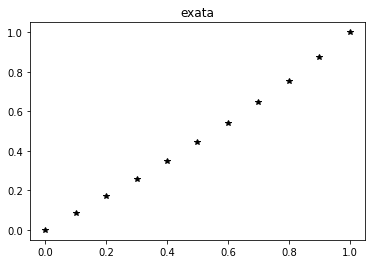

In [4]:
fig=plt.figure(1)
plt.plot(x,yexata(x),'k*')
plt.title('exata')

# MRP - Método dos Resíduos Ponderados

Considere uma equação diferencial em $u(x)$ como mostrado a seguir, e suas condições de contorno.
\begin{equation}
    \left[\begin{matrix}
        L\left[ u\left( x\right) \right] = f\left( x\right); & a \leqslant x \leqslant b \\
        u\left(a \right) = u_{a}; & u\left( b\right) = u_{b}
    \end{matrix}\right.
\end{equation}(1)

A solução aproximada de $u(x)$ é $\bar{u}(x)$ e possui a seguinte forma:
\begin{equation}
    \bar{u}\left( x\right) = \phi_{0}\left( x\right) + \sum_{i=1}^{n}{a_{i}\phi_{i}\left( x\right)}
\end{equation}(2)

Onde $\phi_{i}$ são as funções de aproximação (a princípio arbitrárias) e $a_{i}$ são coeficientes.

Substituindo $\bar{u}$ em (1), tem-se:
\begin{equation}
    L\left[ \bar{u}\left( x\right)\right] - f\left( x\right) = R
\end{equation}(3)

Onde $R$ é denominado Resíduo.

O MRP consiste em ponderar o Resíduo, de modo que a integral ao longo do domínio seja nula. Logo,
\begin{equation}
    \int_{D}{W_{i}R}dv = 0
\end{equation}(4)

(SRP - Sentença de Resíduos Ponderados)

Sendo,
* $W_{i}\rightarrow$ as funções de ponderação;
* $D\rightarrow$ o domínio e;
* $dv\rightarrow$ os diferenciais relativos ao domínio considerado.

### Analogia

É como se houvesse uma compensação de áreas situadas entre $y$ e $\bar{y}$, com ponderação.

(INCLUIR GRÁFICO)

## Subdomínio (MVF - Método dos Volumes Finitos)

### Função de Ponderação

\begin{equation}
    W_{i}\left( x\right) =
    \left[\begin{matrix}
        1 & x \in D\\
        0 & x \notin D
    \end{matrix}\right.
\end{equation}(5)

### Exemplo

Considere a seguinte equação diferencial e suas condições de contorno para a qual obtivemos a Solução Exata.
\begin{equation}
    \left[\begin{matrix}
        \frac{d^{2}u}{dx^{2}}-u=0; & 0 \leqslant x \leqslant 1 \\
        u\left( 0\right)=0 & u\left( 1\right)=1
    \end{matrix}\right.
\end{equation}

A função de aproximação escolhida por simplicidade é um polinômio da forma $x^{i}$. Logo,
\begin{equation}
    \bar{u}\left( x\right) = \sum_{i=0}^{n+1}{C_{i}x^{i}}
\end{equation}

Para que as condições de contorno sejam atendidas, temos:
\begin{equation}
    \bar{u}\left(0\right) = \sum_{i=0}^{n+1}{C_{i}x^{i}} = 0 = \sum_{i=0}^{n+1}{C_{i}0^{i}}
\end{equation}

Mas,
\begin{equation}
    0^{i} =
    \left[\begin{matrix}
        1 & i = 0 \\
        0 & i \neq 0
    \end{matrix}\right.
\end{equation}

Logo,
\begin{equation}
    \sum_{i=0}^{n+1}{C_{i}0^{i}} =
    C_{0}0^{0} + \sum_{i=1}^{n+1}{C_{i}0^{i}} =
    C_{0} + \sum_{i=1}^{n+1}{C_{i}0} = 0
    \therefore C_{0} = 0
\end{equation}

Bem como,

\begin{equation}
    \bar{u}\left(1\right) = 1 \rightarrow
    \sum_{i=1}^{n+1}{C_{i}1^{i}} =
    \sum_{i=1}^{n+1}{C_{i}1} = 1 \therefore
    \sum_{i=1}^{n+1}{C_{i}} = 1
\end{equation}

Logo,
\begin{equation}
    \bar{u}\left(x\right) =
    \sum_{i=1}^{n+1}{C_{i}x^{i}}
\end{equation}

Utilizando $n=1$,

\begin{equation}
    \bar{u}\left(x\right) = C_{1}x + C_{2}x^{2}
\end{equation}

Com $C_{1}+C_{2}=1$.

Assim, tem-se:

\begin{equation}
    R = \frac{d^{2}\bar{u}}{dx^{2}}-\bar{u} = 2C_{2}-C_{1}x-C_{2}x^{2}
\end{equation}

Utilizando o fator de ponderação $W_{i}=1$, tem-se:
\begin{equation}
    \int_{0}^{1}{1\left[2C_{2}-C_{1}x-C_{2}x^{2}\right]}dx =
    \left[2C_{2}x-C_{1}\frac{x^{2}}{2}-C_{2}\frac{x^{3}}{3}\right]_{0}^{1} =
    2C_{2}-\frac{C_{1}}{2}-\frac{C_{2}}{3} = 0
\end{equation}

\begin{equation}
    \left[\begin{matrix}
        -\frac{1}{2}C_{1} + \frac{5}{3}C_{2} & = & 0 \\
        C_{1} + C_{2} & = & 1
    \end{matrix}\right.
\end{equation}

A solução deste sistema é:
\begin{equation}
    \left[\begin{matrix}
        C_{1} & = & \frac{10}{13} \\
        C_{2} & = & \frac{3}{13}
    \end{matrix}\right.
\end{equation}

Logo, tem-se
\begin{equation}
    \bar{u}\left(x\right) = \frac{10}{13}x + \frac{3}{13}x^{2}
\end{equation}

Somando-se e subtraindo-se $\frac{3}{13}x$, obtém-se
\begin{equation}
    \bar{u}\left(x\right) = x + \frac{3}{13}\left(x^{2}-x\right)
\end{equation}

### Implementação do Subdomínio

Abaixo, temos a implementação do MVF e o gráfico comparando com a solução exata.

In [5]:
def ysubdominio(x):
    return x+3/13*x*(x-1)

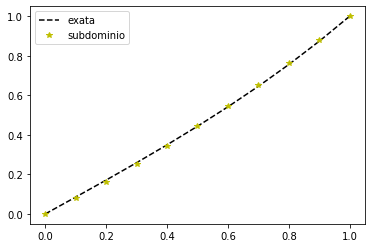

In [6]:
fig=plt.figure(2)
plt.plot(x,yexata(x),'k--',x,ysubdominio(x),'y*')
plt.legend(('exata','subdominio'))

## Galerkin

No Método de Galerkin, a Função de Ponderação é igual a Função de Aproximação. Logo,

\begin{equation}
    \begin{matrix}
        W_{i}\left(x\right) = \phi_{i}\left(x\right) & \left( i=1,2,3,\dots ,n\right)
    \end{matrix}
\end{equation}

E a SRP - Sentença de Resíduos Ponderados, torna-se:
\begin{equation}
    \int_{D}{\phi_{i}R}dv = 0
\end{equation}

Considere a mesma equação diferencial e as mesmas condições de contorno do exemplo anterior.
\begin{equation}
    \left[\begin{matrix}
        \frac{d^{2}u}{dx^{2}}-u=0; & 0 \leqslant x \leqslant 1 \\
        u\left( 0\right)=0 & u\left( 1\right)=1
    \end{matrix}\right.
\end{equation}

Adota-se $W_{i}\left(x\right) = \phi_{i}\left(x\right) = x(x-1)$, com $n=1$.

A SRP torna-se
\begin{equation}
        \begin{matrix}
        \int_{0}^{1}{W_{i}R}dx =
        \int_{0}^{1}{W_{i}\left(\frac{d^{2}\bar{u}}{dx^{2}}-\bar{u}\right)}dx =\\
        \left[W_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} - \int_{0}^{1}{\left(\frac{dW_{i}}{dx}\frac{d\bar{u}}{dx}\right)}dx - \int_{0}^{1}{W_{i}\bar{u}}dx = 0
    \end{matrix}
\end{equation}

Lembrando que o resultado acima sai a partir da integração por partes, onde,
\begin{equation}
    \int{u}dv = uv-\int{v}du
\end{equation}

E, portanto,
\begin{equation}
    \int{W_{i}\frac{d^{2}\bar{u}}{dx^{2}}}dx =
    \left[W_{i}\frac{d\bar{u}}{dx}\right] - \int{\left(\frac{dW_{i}}{dx}\frac{d\bar{u}}{dx}\right)}dx
\end{equation}

Porém,
\begin{equation}
    \left[W_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} = 0
\end{equation}

Pois $W = x(x-1) = 0$ para $x=0$ e $x=1$. Logo,
\begin{equation}
    \begin{matrix}
        -\int_{0}^{1}{\left(\frac{d\phi_{i}}{dx}\frac{d\bar{u}}{dx}\right)}dx - \int_{0}^{1}{\phi_{i}\bar{u}}dx = 0\\
        -\int_{0}^{1}{\left(2x-1\right)\left(C_{1}+2C_{2}x\right)}dx - \int_{0}^{1}{\left(x^{2}-x\right)\left(C_{1}x+C_{2}x^{2}\right)}dx = 0 \\
        \int_{0}^{1}{\left(2C_{1}x + 4C_{2}x^{2} - C_{1} - 2C_{2}x\right)}dx + \\
        \int_{0}^{1}{\left(C_{1}x^{3} + C_{2}x^{4} - C_{1}x^{2} - C_{2}x^{3}\right)}dx = 0 \\
        \left[\frac{2}{2}C_{1}x^{2} + \frac{4}{3}C_{2}x^{3} - C_{1}x - \frac{2}{2}C_{2}x^{2}\right]_{0}^{1} + \\
        \left[\frac{1}{4}C_{1}x^{4} + \frac{1}{5}C_{2}x^{5} - \frac{1}{3}C_{1}x^{3} - \frac{1}{4}C_{2}x^{4}\right]_{0}^{1} = 0
    \end{matrix}
\end{equation}

Logo, simplificando,
\begin{equation}
    \begin{matrix}
        \not{C_{1}} + \frac{4}{3}C_{2} - \not{C_{1}} - C_{2} + \frac{1}{4}C_{1} + \frac{1}{5}C_{2} - \frac{1}{3}C_{1} - \frac{1}{4}C_{2} = \\
        \left(\frac{1}{4}-\frac{1}{3}\right)C_{1} + \left(\frac{4}{3}-1+\frac{1}{5}-\frac{1}{4}\right)C_{2} = 0 \\
        \left(\frac{3-4}{12}\right)C_{1} + \left(\frac{80-60+12-15}{60}\right)C_{2} = 0 \\
        -\frac{1}{12}C_{1}\left(\frac{5}{5}\right)+\frac{17}{60}C_{2} = 0
    \end{matrix}
\end{equation}

Portanto,
\begin{equation}
    \left[\begin{matrix}
        -5C_{1} & + & 17C_{2} & = & 0 \\
        C_{1} & + & C_{2} & = & 0
    \end{matrix}\right.
\end{equation}

A solução desse sistema é:
\begin{equation}
    \left[\begin{matrix}
        C_{1} & = & \frac{17}{22} \\
        C_{2} & = & \frac{5}{22}
    \end{matrix}\right.
\end{equation}

Assim,
\begin{equation}
    \bar{u}\left(x\right) = x + \frac{5}{22}x\left(x-1\right)
\end{equation}

### Implementação do Método de Galerkin

Abaixo, segue a implementação do Método de Galerkin e o gráfico comparando a solução exata.

In [7]:
def ygalerkin(x):
    return x+5/22*x*(x-1)

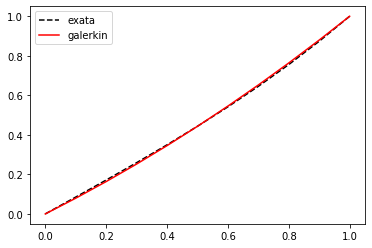

In [8]:
fig=plt.figure(3)
plt.plot(x,yexata(x),'k--',x,ygalerkin(x),'r-')
plt.legend(('exata','galerkin'))

## Rayleigh-Ritz

É utilizado quando existe um Funcinoal equivalente à uma equação diferencial.

* PTV - Princípio dos Trabalhos Virtuais
* EPM - Energia Potencial Mínima

Considere $\Pi(u)$ o funcional equivalente à equação diferencial
\begin{equation}
    \frac{d^{2}u}{dx^{2}} - u = 0
\end{equation}

O MRR - Método de Rayleigh-Ritz considera que a solução aproximada $\bar{u}(x)$ é uma combinação linear de funções de aproximação $\phi_{i}(x)$, ou seja,
\begin{equation}
    \bar{u}\left(x\right) = \sum_{i=1}^{n}{a_{i}\phi_{i}\left(x\right)}
\end{equation}

Sendo $a_{i}, (i=1.2.\dots,n)$ coeficientes arbitrários e $\phi_{i}(x)$ devem ser escolhidos para atenderem as condições de contorno:
\begin{equation}
    \left[\begin{matrix}
        \sum_{i=1}^{n}{a_{i}\phi_{i}\left(a\right)} & = & u_{a} \\
        \sum_{i=1}^{n}{a_{i}\phi_{i}\left(b\right)} & = & u_{b}
    \end{matrix}\right.
\end{equation}

A solução aproximada $\bar{y}$ deve tornar o Funcional "estacionário" em relação às constantes $a_{i}$, ou seja, nulo. Logo,
\begin{equation}
    \begin{matrix}
        \frac{\partial \Pi}{\partial  a_{i}} = 0 & \left(i=1,2,\dots ,n\right)
    \end{matrix}
\end{equation}

O Funcional $\Pi$ da equação diferencial $\frac{d^{2}u}{dx^{2}}-u=0$ vale
\begin{equation}
    \Pi\left(u\right) = \int_{0}^{1}{\left[\frac{1}{2}\left(\frac{du}{dx}\right)^{2}+\frac{1}{2}u^{2}\right]}dx
\end{equation}

Supondo $\bar{u}=x+ax(x+1)$,
\begin{equation}
    \begin{matrix}
        \Pi\left(\bar{u}\right) = \int_{0}^{1}{\left[\frac{1}{2}\left(1+a\left(2x-1\right)\right)^{2}+\frac{1}{2}\left(x+a\left(x^{2}-x\right)\right)^{2}\right]}dx \\
        \Pi\left(\bar{u}\right) = \frac{2}{3} - \frac{a}{12} + \frac{a^{2}}{3}
    \end{matrix}
\end{equation}

Como
\begin{equation}
    \begin{matrix}
        \frac{\partial\Pi\left(\bar{u}\right)}{\partial a} = 0 \therefore -\frac{1}{12} + \frac{2}{3}a = 0 \\
        a = \frac{1}{8}
    \end{matrix}
\end{equation}

Portanto,
\begin{equation}
    \bar{u}\left(x\right) = x + \frac{1}{8}x\left(x-1\right)
\end{equation}

### Implementação do Método de Rayleigh-Ritz

A seguir, a implementação do Método de Rayleigh-Ritz, bem como o gráfico de comparação com a solução exata.

In [9]:
def yRR (x):
    return x+1/8*x*(x-1)

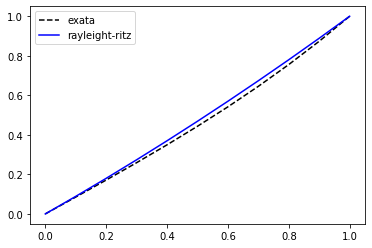

In [10]:
fig=plt.figure(4)
plt.plot(x,yexata(x),'k--',x,yRR(x),'b-')
plt.legend(('exata','rayleight-ritz'))

## MEF - Método dos Elementos Finitos

O Método dos Elementos Finitos pode ser entendido como derivado do Método de Galerkin, onde, na SRP (Sentença de Resíduos Ponderados), $W_{i}=\phi_{i}$, considera-se o domínio $1-D$ (unidimensional) dividido em segmentos ou elementos, sendo os seus pontos extremos denominados nós.

(INSERIR IMAGEM)

Tem-se que:
\begin{equation}
    \bar{u} = \sum_{i=1}^{n+1}{u_{i}N_{i}\left(x\right)}
\end{equation}

No segmento $e$, temos:
\begin{equation}
    h_{e} = x_{e}^{\left(2\right)} - x_{e}^{\left(1\right)}
\end{equation}

E, tem-se que
\begin{equation}
    \bar{u}\left(x\right) = \sum_{i=1}^{n+1}{u_{i}N_{i}\left(x\right)}
\end{equation}

Assim, localmente,
\begin{equation}
    N_{1}\left(e\right) = \frac{x_{e}^{\left(2\right)}-x}{x_{e}^{\left(2\right)}-x_{e}^{\left(1\right)}} =
    \frac{x_{e}^{\left(2\right)}-x_{e}^{\left(1\right)}-x_{e}}{x_{e}^{\left(2\right)}-x_{e}^{\left(1\right)}}
\end{equation}

\begin{equation}
    \begin{matrix}
        N_{1}\left(e\right) = \frac{h_{e}-x_{e}}{h_{e}} &
        \left[\begin{matrix}
            N_{1}\left(x_{e}\right) = 1 \\
            N_{1}\left(h_{e}\right) = 0
        \end{matrix}\right.
    \end{matrix}
\end{equation}

\begin{equation}
    N_{2}\left(e\right) = \frac{x-x_{e}^{\left(1\right)}}{x_{e}^{\left(2\right)}-x_{e}^{\left(1\right)}}
\end{equation}

\begin{equation}
    \begin{matrix}
        N_{1}\left(e\right) = \frac{x_{e}}{h_{e}} &
        \left[\begin{matrix}
            N_{2}\left(x_{e}\right) = 0 \\
            N_{2}\left(h_{e}\right) = 1
        \end{matrix}\right.
    \end{matrix}
\end{equation}

Usando o Método de Galerkin na SRP, temos:
\begin{equation}
    \int_{0}^{1}{N_{i}R}dx = 0
\end{equation}

Ou,
\begin{equation}
    \begin{matrix}
        \int_{0}^{1}{N_{i}\left(\frac{d^{2}\bar{u}}{dx^{2}}-\bar{u}\right)}dx = \\
        \left[N_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} - \int_{0}^{1}{\left(\frac{dN_{i}}{dx}\frac{d\bar{u}}{dx}+N_{i}\bar{u}\right)}dx = 0
    \end{matrix}
\end{equation}

Logo, lembrando que
\begin{equation}
    \bar{u}\left(x\right) = \sum_{i=1}^{n+1}{u_{i}N_{i}\left(x\right)}
\end{equation}

Obtém-se
\begin{equation}
    \begin{matrix}
        \sum_{j=1}^{n+1}{\int_{0}^{1}{\left[\left(\frac{dN_{i}}{dx}\frac{dN_{j}}{dx}\right)u_{j} + \left(N_{i}N_{j}\right)u_{j}\right]}dx} -
        \left[N_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} = 0 \\
        \therefore \\
        \sum_{j=1}^{n+1}{\int_{0}^{1}{\left(\frac{dN_{i}}{dx}\frac{dN_{j}}{dx} + N_{i}N_{j}\right)}u_{j}dx} -
        \left[N_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} = 0
    \end{matrix}
\end{equation}

A partir da equação acima, define-se a <b><i>Matriz de Rigidez</i></b> $K$.

### Matriz de Rigidez e Matriz de Força (ou Carregamento) Nodal

\begin{equation}
    \begin{matrix}
        K_{ij} \equiv \int_{0}^{1}{\left(\frac{dN_{i}}{dx}\frac{dN_{j}}{dx} + N_{i}N_{j}\right)}dx & \left(i,j\right)\geqslant 1 \\
        f_{i} \equiv \left[N_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} & \left(i,j\right) \leqslant n+1
    \end{matrix}
\end{equation}

### MEF com 1 Elemento

In [11]:
def yFEM1E (x):
    return x

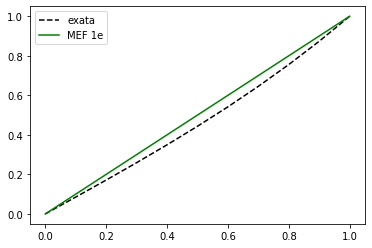

In [12]:
fig=plt.figure(5)
plt.plot(x,yexata(x),'k--',x,yFEM1E(x),'g-')
plt.legend(('exata','MEF 1e'))

### MEF com 3 Elementos

In [13]:
xfemtres=array([0.,0.333,0.667,1.])
yfemtres=array([0,0.2885,0.6098,1.])
ylin=interp1d(xfemtres,yfemtres,kind='linear')(x)

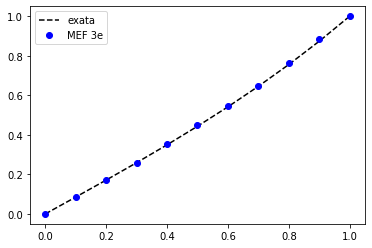

In [14]:
fig=plt.figure(6)
plt.plot(x,yexata(x),'k--',x,ylin,'bo')
plt.legend(('exata','MEF 3e'))

## Comparação das Soluções

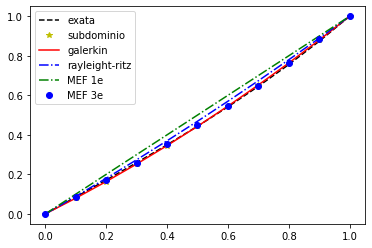

In [15]:
fig=plt.figure(7)
plt.plot(x,yexata(x),'k--', x,ysubdominio(x),'y*',x,ygalerkin(x),'r-',x,yRR(x),'b-.',x,yFEM1E(x),'g-.',x,ylin,'bo')
plt.legend(('exata','subdominio','galerkin','rayleight-ritz','MEF 1e','MEF 3e'))

## Cálculo Variacional, Funcional, PTV - Princípio dos Trabalhos Virtuais